# Training & Evaluation

This notebook covers the training and evaluation of the churn prediction model using both traditional demographic features and graph-based features derived from Neo4j's Graph Data Science library. The goal is to identify users at risk of churning based on their transaction behavior and network relationships.

In [1]:
# Load .env variables
from dotenv import load_dotenv
import os
import logging

load_dotenv()
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE", "neo4j")


# Set the logging level for the 'neo4j' module to ERROR
logging.getLogger("neo4j").setLevel(logging.ERROR)

In [2]:
# Open session with Neo4j
from neo4j import GraphDatabase

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
session = driver.session(database=NEO4J_DATABASE)

## Graph Schema Visualization
Define a function to visualize the Neo4j database schema using NetworkX.

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_schema(session, uri, auth):
    driver = GraphDatabase.driver(uri, auth=auth)
    
    query = "CALL db.schema.visualization()"
    
    G = nx.DiGraph()
    
    with session.begin_transaction() as tx:
        result = tx.run(query)
        record = result.single()
        
        # Parse Nodes (Labels)
        # The schema query returns nodes that represent the Labels themselves.
        # We use the 'name' property (or the first label) as the node ID.
        for node in record["nodes"]:
            # Schema nodes usually have the label name as a property or as the label itself
            # In modern Neo4j, the node usually has labels like ["User"] and properties like {name: "User"}
            label = list(node.labels)[0] if node.labels else "Unknown"
            # Sometimes the schema node has a property 'name' containing the label
            if "name" in node.keys():
                label = node["name"]
            
            G.add_node(label, type="Node")

        # Parse Relationships
        for rel in record["relationships"]:
            start_node = rel.start_node
            end_node = rel.end_node
            
            # Extract label names for start/end
            src = start_node["name"] if "name" in start_node.keys() else list(start_node.labels)[0]
            dst = end_node["name"] if "name" in end_node.keys() else list(end_node.labels)[0]
            
            rel_type = rel.type
            
            G.add_edge(src, dst, label=rel_type)
            
    driver.close()

    # Draw with NetworkX
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=1.5, iterations=100) # 'k' controls the spacing
    
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', edgecolors='black')
    
    # Draw Labels
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='normal')
    
    # Draw Edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)
    
    # Draw Edge Labels (The Relationship Types)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, font_size=11, edge_labels=edge_labels, font_color='black')
    
    plt.title("Graph Schema Visualization")
    plt.axis('off')
    plt.show()

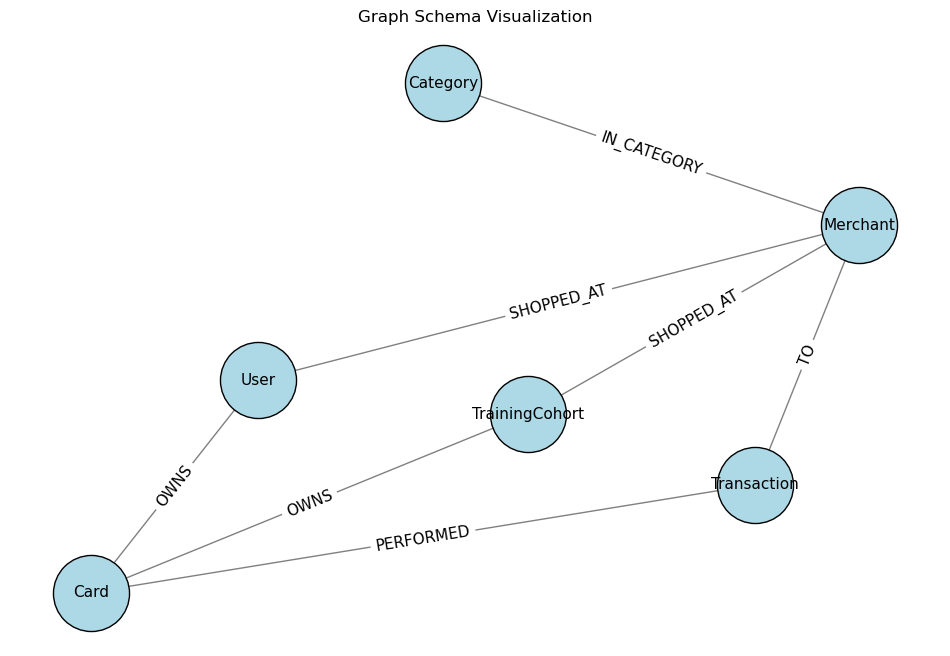

In [4]:
draw_schema(session, NEO4J_URI, (NEO4J_USER, NEO4J_PASSWORD))

## Helper Functions
Define a helper function to execute Cypher queries.

In [5]:
def run_cypher(session, query, parameters=None):
    results = []
    with session.begin_transaction() as tx:
        for statement in query.split(';'):
            if statement.strip():
                result = tx.run(statement, parameters)
                # Just consume the data directly
                data = result.data()
                if data:
                    results.append(data)
    
    return results[-1] if results else []

def run_cypher_list(session, query, parameters=None):
    results = []
    with session.begin_transaction() as tx:
        for statement in query.split(';'):
            if statement.strip():
                result = tx.run(statement, parameters)
                records = list(result)
                if records:
                    results.append(records)
    
    return results[-1] if results else []

In [6]:
# A method to plot returned results from Cypher queries
from matplotlib.lines import Line2D
from neo4j.graph import Node, Relationship, Path

def draw_graph(data, figsize=(12, 8), node_size=1000, font_size=10, show_labels=False):
    """
    Plots a graph from a Neo4j query result with a CORRECT Legend.
    """
    
    # Initialize NetworkX Graph
    G = nx.DiGraph()
    
    # ------------------------------------------------------------------
    # Helper functions to parse Neo4j objects
    # ------------------------------------------------------------------
    def add_node(node):
        uid = getattr(node, "element_id", getattr(node, "element_id", None))
        labels = list(node.labels)
        main_label = labels[0] if labels else "Node"
        display_text = node.get("element_id", node.get("name", node.get("city", main_label)))
        G.add_node(uid, label=display_text, group=main_label)

    def add_rel(rel):
        start_uid = getattr(rel.start_node, "element_id", getattr(rel.start_node, "element_id", None))
        end_uid = getattr(rel.end_node, "element_id", getattr(rel.end_node, "element_id", None))
        rel_type = rel.type
        G.add_edge(start_uid, end_uid, label=rel_type)

    # ------------------------------------------------------------------
    # Parse Data
    # ------------------------------------------------------------------
    for row in data:
        for key, val in row.items():
            if isinstance(val, Path):
                for node in val.nodes: add_node(node)
                for rel in val.relationships: add_rel(rel)
            elif isinstance(val, Node):
                add_node(val)
            elif isinstance(val, Relationship):
                add_rel(val)
                add_node(val.start_node)
                add_node(val.end_node)
            elif isinstance(val, list):
                for item in val:
                    if isinstance(item, Node): add_node(item)
                    elif isinstance(item, Relationship): 
                        add_rel(item)
                        add_node(item.start_node)
                        add_node(item.end_node)
                    elif isinstance(item, Path):
                        for n in item.nodes: add_node(n)
                        for r in item.relationships: add_rel(r)

    if G.number_of_nodes() == 0:
        print("No graph data found to plot.")
        return

    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    groups = sorted(list(set(nx.get_node_attributes(G, 'group').values())))
    cmap = plt.cm.get_cmap('tab10', len(groups)) 
    group_color_map = {group: cmap(i) for i, group in enumerate(groups)}
    node_colors = [group_color_map[G.nodes[n]['group']] for n in G.nodes]

    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, alpha=0.9)
    
    # Draw Edges
    nx.draw_networkx_edges(G, pos, width=0.75, alpha=0.6, arrowsize=10, arrowstyle='->')
    
    # Labels
    if show_labels:
        node_labels = nx.get_node_attributes(G, 'label')
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=font_size, font_weight="bold")
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=font_size-2)

    legend_elements = []
    for group_name, color in group_color_map.items():
        # Use the exact same RGB color from our map
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', label=group_name,
                   markerfacecolor=color, markersize=15)
        )
    
    plt.legend(handles=legend_elements, loc='upper right', title="Node Types")
    plt.axis('off')
    plt.title(f"Graph Visualization ({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)")
    plt.show()

## Define Cypher Queries
Here we define all the Cypher queries required for the GDS pipeline. This includes cleanup, data preparation, graph projection, feature engineering, model training, and inference.

In [7]:
# Define all necessary queries which we will be using later
queries = {
    # -------------------------------------------------------------------------
    # SETUP & CLEANUP
    # -------------------------------------------------------------------------
    "01_cleanup": """
        CALL gds.graph.drop('churnGraph', false);
        CALL gds.graph.drop('fullGraph', false);
        CALL gds.beta.pipeline.drop('churnPipeline', false);
        CALL gds.model.drop('churnModel', false);
    """,

    "02_remove_temp_labels": """
        MATCH (u:TrainingCohort) REMOVE u:TrainingCohort;
    """,

    # -------------------------------------------------------------------------
    # DATA PREPARATION (Undersampling & Materialization)
    # -------------------------------------------------------------------------
    "03_prepare_data": """
        // 1. Label the Training Cohort (Undersampling)
        MATCH (u:User)
        WHERE u.churned = 1 OR rand() < 0.05
        SET u:TrainingCohort;

        // 2. Materialize the Relationship for EVERYONE (needed for both graphs)
        // Note: Doing this for all users now saves time later
        MATCH (u:User)-[:OWNS]->(:Card)-[:PERFORMED]->(t:Transaction)-[:TO]->(m:Merchant)
        WITH u, m, count(t) AS weight
        MERGE (u)-[r:SHOPPED_AT]->(m)
        SET r.weight = weight;
    """,

    # -------------------------------------------------------------------------
    # TRAINING PHASE
    # -------------------------------------------------------------------------
    "04_project_training_graph": """
        CALL gds.graph.project(
            'churnGraph',
            {
                TrainingCohort: {
                    properties: ['churned', 'yearly_income', 'total_debt', 'credit_score']
                },
                Merchant: { properties: [] }
            },
            {
                SHOPPED_AT: {
                    orientation: 'UNDIRECTED',
                    properties: 'weight'
                }
            }
        );
    """,

    "05_features_training": """
        // Feature Engineering on TRAINING Graph
        CALL gds.fastRP.mutate('churnGraph', {
            embeddingDimension: 32, 
            relationshipWeightProperty: 'weight',
            mutateProperty: 'embedding_fastrp'
        });

        CALL gds.pageRank.mutate('churnGraph', {
            relationshipWeightProperty: 'weight',
            mutateProperty: 'score_pagerank'
        });
    """,

    "06_configure_pipeline": """
        // 1. Create Pipeline
        CALL gds.beta.pipeline.nodeClassification.create('churnPipeline');

        // 2. Select Features
        CALL gds.beta.pipeline.nodeClassification.selectFeatures('churnPipeline', [
            'embedding_fastrp', 
            'score_pagerank', 
            'yearly_income', 
            'total_debt', 
            'credit_score'
        ]);

        // 3. Configure Split (Low folds for small data)
        CALL gds.beta.pipeline.nodeClassification.configureSplit('churnPipeline', {
            testFraction: 0.2,
            validationFolds: 2
        });

        // 4. Add Model
        CALL gds.beta.pipeline.nodeClassification.addRandomForest('churnPipeline', {
            numberOfDecisionTrees: 50,
            maxDepth: 5,
            minLeafSize: 1,
            minSplitSize: 2
        });
    """,

    "07_train_model": """
        CALL gds.beta.pipeline.nodeClassification.train(
            'churnGraph',
            {
                pipeline: 'churnPipeline',
                targetNodeLabels: ['TrainingCohort'], 
                modelName: 'churnModel',
                targetProperty: 'churned',
                metrics: ['ACCURACY', 'OUT_OF_BAG_ERROR', 'PRECISION(class=1)', 'RECALL(class=1)']
            }
        )
        YIELD modelInfo, modelSelectionStats
        RETURN 
            modelInfo.metrics.ACCURACY AS Accuracy,
            modelInfo.metrics['PRECISION(class=1)'] AS Precision,
            modelInfo.metrics['RECALL(class=1)'] AS Recall;
    """,

    # -------------------------------------------------------------------------
    # INFERENCE PHASE (Predicting on Everyone)
    # -------------------------------------------------------------------------
    "08_project_inference_graph": """
        // Project the FULL graph (All Users)
        CALL gds.graph.project(
            'fullGraph',
            {
                User: {
                    properties: ['churned', 'yearly_income', 'total_debt', 'credit_score']
                },
                Merchant: { properties: [] }
            },
            {
                SHOPPED_AT: {
                    orientation: 'UNDIRECTED',
                    properties: 'weight'
                }
            }
        );
    """,

    "09_features_inference": """
        // Feature Engineering on FULL Graph
        // MUST match the exact settings from '05_features_training'
        CALL gds.fastRP.mutate('fullGraph', {
            embeddingDimension: 32, 
            relationshipWeightProperty: 'weight',
            mutateProperty: 'embedding_fastrp'
        });

        CALL gds.pageRank.mutate('fullGraph', {
            relationshipWeightProperty: 'weight',
            mutateProperty: 'score_pagerank'
        });
    """,

    "10_predict_churn": """
        CALL gds.beta.pipeline.nodeClassification.predict.stream(
            'fullGraph',
            {
                modelName: 'churnModel',
                includePredictedProbabilities: true,
                targetNodeLabels: ['User'] // Apply the logic learned on 'TrainingCohort' to 'User'
            }
        )
        YIELD nodeId, predictedClass, predictedProbabilities
        WITH 
            gds.util.asNode(nodeId) AS user, 
            predictedClass,
            predictedProbabilities[1] AS Risk_Score

        // Filter: Show 'Active' users that the model thinks are risky
        WHERE user.churned = 0

        RETURN 
            user.id AS UserID, 
            user.yearly_income AS Income,
            user.credit_score AS Credit_Score,
            Risk_Score, 
            predictedClass
        ORDER BY Risk_Score DESC
        LIMIT 25;
    """,
    "11_visualize_churn_network": """
        // 1. Stream the prediction scores directly from memory
        CALL gds.beta.pipeline.nodeClassification.predict.stream(
            'fullGraph',
            {
                modelName: 'churnModel',
                targetNodeLabels: ['User'],
                includePredictedProbabilities: true
            }
        )
        YIELD nodeId, predictedProbabilities
        
        // 2. Grab the Top Riskiest Users (Risk Score is at index [1])
        // We do this sorting in memory, which is very fast
        WITH gds.util.asNode(nodeId) AS u, predictedProbabilities[1] AS risk_score
        WHERE u.churned = 0
        ORDER BY risk_score DESC
        LIMIT 5
        
        // 3. Match the Network for these specific users
        MATCH path = (c:Card)-[:OWNS]-(u)-[:SHOPPED_AT]-(m:Merchant)
        RETURN path
    """
}

## 1. Setup & Data Preparation
Execute the initial steps:
1.  **Cleanup**: Remove old graphs and pipelines.
2.  **Data Prep**: Undersample the majority class (active users) to create a balanced `TrainingCohort` and materialize the `SHOPPED_AT` relationship.
3.  **Graph Projection**: Project the training graph into memory.

**What is a Projection?**
In Neo4j GDS, algorithms run on an in-memory graph projection, not directly on the database storage. This projection is a highly optimized, read-only data structure. We define which nodes (e.g., `User`, `Merchant`) and relationships (e.g., `SHOPPED_AT`) to load into RAM for analysis.

In [8]:
# 01
run_cypher(session, queries["01_cleanup"])

# 02
run_cypher(session, queries["02_remove_temp_labels"])

# 03
run_cypher(session, queries["03_prepare_data"])

# 04
run_cypher(session, queries["04_project_training_graph"])

[{'nodeProjection': {'Merchant': {'properties': {}, 'label': 'Merchant'},
   'TrainingCohort': {'properties': {'yearly_income': {'property': 'yearly_income',
      'defaultValue': None},
     'credit_score': {'property': 'credit_score', 'defaultValue': None},
     'total_debt': {'property': 'total_debt', 'defaultValue': None},
     'churned': {'property': 'churned', 'defaultValue': None}},
    'label': 'TrainingCohort'}},
  'relationshipProjection': {'SHOPPED_AT': {'orientation': 'UNDIRECTED',
    'aggregation': 'DEFAULT',
    'type': 'SHOPPED_AT',
    'properties': {'weight': {'property': 'weight',
      'aggregation': 'DEFAULT',
      'defaultValue': None}},
    'indexInverse': False}},
  'graphName': 'churnGraph',
  'nodeCount': 68510,
  'relationshipCount': 40872,
  'projectMillis': 656}]

## Verify Schema Changes
Visualize the schema again to confirm that the `SHOPPED_AT` relationships have been created.

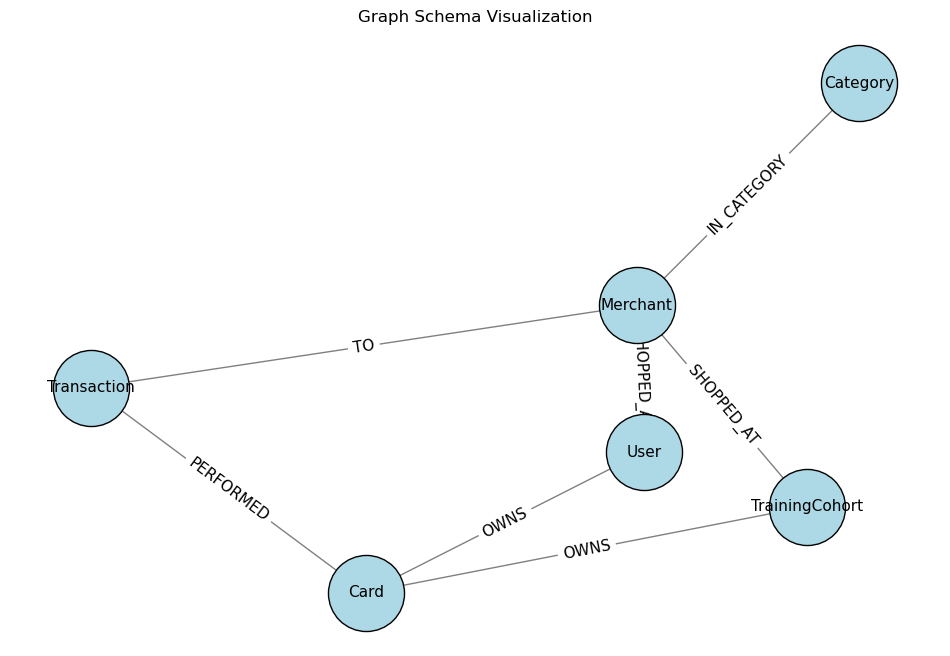

In [17]:
draw_schema(session, NEO4J_URI, (NEO4J_USER, NEO4J_PASSWORD))

## 2. Feature Engineering (Training)
Generate graph features for the training cohort:
*   **FastRP**: Node embeddings.
*   **PageRank**: Centrality scores.

**FastRP (Fast Random Projection)** is a node embedding algorithm that transforms the graph topology into fixed-length vectors (embeddings). It captures the structural role of a node and its neighborhood.

**PageRank** measures the importance of a node within the graph based on the number and quality of incoming relationships. In this context, it helps identify influential users or merchants in the transaction flow.

In [10]:
import pandas as pd

# 05
res = run_cypher(session, queries["05_features_training"])
df = pd.DataFrame(res)
display(df)

,ranIterations,didConverge,centralityDistribution,preProcessingMillis,computeMillis,postProcessingMillis,mutateMillis,nodePropertiesWritten,configuration
0,20,False,"{'p99': 0.6470937728881836, 'min': 0.149999618...",0,42,8,0,68510,"{'maxIterations': 20, 'relationshipWeightPrope..."


## 3. Pipeline Configuration
Create and configure the classification pipeline:
*   Select features (embeddings, PageRank, demographic properties).
*   Configure cross-validation split.
*   Add a Random Forest model.

In [11]:
# 06
res = run_cypher(session, queries["06_configure_pipeline"])
df = pd.DataFrame(res)
display(df)

,name,nodePropertySteps,featureProperties,splitConfig,autoTuningConfig,parameterSpace
0,churnPipeline,[],"[embedding_fastrp, score_pagerank, yearly_inco...","{'testFraction': 0.2, 'validationFolds': 2}",{'maxTrials': 10},"{'MultilayerPerceptron': [], 'LogisticRegressi..."


## 4. Model Training
Train the model on the `churnGraph` using the `TrainingCohort` nodes. We evaluate using Accuracy, Precision, and Recall.

In [12]:
# 07
res = run_cypher(session, queries["07_train_model"])
df = pd.DataFrame(res)
display(df)

,Accuracy,Precision,Recall
0,"{'test': 0.8125, 'outerTrain': 0.953125, 'vali...",None,None


## 5. Inference Graph Projection
Now that the model is trained, we project the **full graph** (all users) to run predictions on everyone.

In [13]:
# 08
res = run_cypher(session, queries["08_project_inference_graph"])
df = pd.DataFrame(res)
display(df)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Merchant': {'properties': {}, 'label': 'Merc...","{'SHOPPED_AT': {'orientation': 'UNDIRECTED', '...",fullGraph,69649,634312,1077


## 6. Feature Engineering (Inference)
Generate the same graph features (FastRP, PageRank) for the full graph. **Crucial:** The parameters must match the training phase exactly.

In [14]:
# 09
res = run_cypher(session, queries["09_features_inference"])
df = pd.DataFrame(res)
display(df)

,ranIterations,didConverge,centralityDistribution,preProcessingMillis,computeMillis,postProcessingMillis,mutateMillis,nodePropertiesWritten,configuration
0,20,False,"{'p99': 24.258788108825684, 'min': 0.151714324...",0,92,11,0,69649,"{'maxIterations': 20, 'relationshipWeightPrope..."


## 7. Predict Churn
Apply the trained model to the full graph to predict the churn probability for **active** users. We list the top 25 users with the **highest** churn risk scores predicted by the model.

In [15]:
# 10
res = run_cypher(session, queries["10_predict_churn"])
df = pd.DataFrame(res)
display(df)

,UserID,Income,Credit_Score,Risk_Score,predictedClass
0,58,52512.0,706,0.56,1
1,751,49677.0,593,0.54,1
2,1858,26481.0,705,0.54,1
3,1762,63583.0,635,0.52,1
4,1882,59322.0,694,0.52,1
5,581,29962.0,684,0.52,1
6,1324,38872.0,663,0.52,1
7,1248,43386.0,698,0.52,1
8,1685,74012.0,681,0.52,1
9,1303,61937.0,684,0.52,1


We can also visualise the predicted churn network as a graph.

/var/folders/y6/pdtk142j2hs__2lwm72sfv2m0000gn/T/ipykernel_69334/2984810975.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(groups))


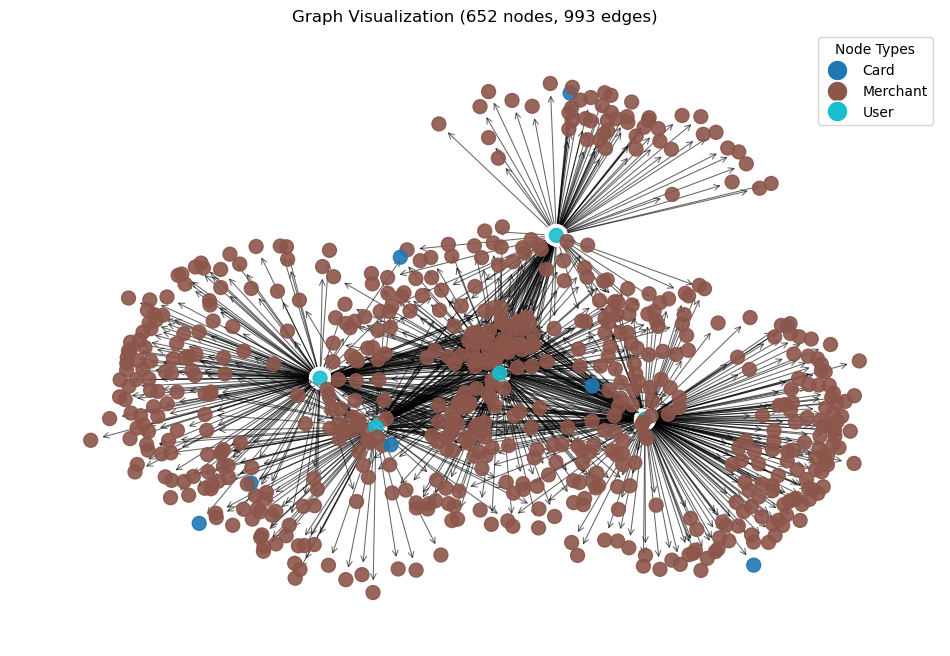

In [16]:
# 11
res = run_cypher_list(session, queries["11_visualize_churn_network"])

draw_graph(res, node_size=100)